## Import Library

In [ ]:
import os
from PIL import Image

import pandas as pd

from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torchvision.models import vgg16
from torchvision.models import resnet50
import time
from torch.autograd import Variable
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

## Data Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
print(os.listdir('/content/drive/MyDrive'))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['Data tablet', '2511', 'Colab Notebooks', 'FaceRecognition']


In [ ]:
!ls "/content/drive/MyDrive"
!ls "/content/drive/MyDrive/FaceRecognition"

 2511  'Colab Notebooks'  'Data tablet'   FaceRecognition
Dataset


In [ ]:
if os.path.exists(data_path):
    print(f"Directory found: {data_path}")
    os.listdir(data_path)
else:
    print(f"Directory not found: {data_path}")

Directory found: /content/drive/MyDrive/FaceRecognition


In [ ]:
!find "/content/drive/MyDrive/FaceRecognition" -type d -name Images

/content/drive/MyDrive/FaceRecognition/Dataset/Images


In [ ]:
import os
import pandas as pd

# Path ke dataset utama
data_path = '/content/drive/MyDrive/FaceRecognition/Dataset'
image_folder = os.path.join(data_path, 'Images')

# Load CSV dan TXT
gender_csv = os.path.join(data_path, 'gender_classification.csv')
identity_txt = os.path.join(data_path, 'class_identity.txt')

identity_df = pd.read_csv(identity_txt, sep=' ', header=None, names=['image_filename', 'identity'])
gender_df = pd.read_csv(gender_csv)

# Validasi file gambar yang memang ada
valid_files = set(os.listdir(image_folder))
identity_df = identity_df[identity_df['image_filename'].isin(valid_files)].reset_index(drop=True)

# Gabungkan label gender
min_len = min(len(identity_df), len(gender_df))
identity_df = identity_df.iloc[:min_len].reset_index(drop=True)
gender_df = gender_df.iloc[:min_len].reset_index(drop=True)

identity_df['gender'] = gender_df['Male']

# Cek hasil
print(identity_df.head())
print(identity_df.shape)

  image_filename  identity  gender
0     000051.jpg      1446       1
1     000052.jpg      3896       1
2     000352.jpg      2753       1
3     000409.jpg      8226       0
4     000545.jpg      8346       0
(1768, 3)


In [ ]:
# split the data into train and test sets with a 80:20 ratio
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

## Preprocessing

In [ ]:
class GenderDataset(Dataset):
    def __init__(self, data, image_folder_path, transform=None):
        self.data = data
        self.image_folder_path = image_folder_path
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_filename = self.data.iloc[idx]['image_filename']
        image_path = os.path.join(self.image_folder_path, image_filename)
        image = Image.open(image_path).convert('RGB')
        gender = self.data.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(gender, dtype=torch.long)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Buat objek Dataset
train_dataset = GenderDataset(train_data, image_folder_path=data_path + '/Images', transform=transform)
val_dataset = GenderDataset(test_data, image_folder_path=data_path + '/Images', transform=transform)

# Buat DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

dataloaders = {
    'train': train_loader,
    'val': val_loader
}

dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset)
}

In [ ]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize(218),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [ ]:
from torchvision import datasets, transforms

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]),
}

In [ ]:
print(train_data.head())
print(os.listdir(os.path.join(data_path, "Images"))[:5])

      Male
4227     0
4676     0
800      0
3671     1
4193     0
['029738.jpg', '088225.jpg', '088136.jpg', '133834.jpg', '090009.jpg']


In [ ]:
train_set = GenderDataset(train_data, image_folder_path=os.path.join(data_path, "Images"), transform=transform)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)

test_set = GenderDataset(test_data, os.path.join(data_path, "Images"), transform=transform)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=2)



## Architecture VGG

In [ ]:
# DEFINE MODEL
model = torchvision.models.vgg16(pretrained=True)
optimizer = optim.Adam(model.parameters(),lr=0.0001)
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 78.1MB/s]


## Modeling

In [ ]:
#SETUP DATA LOADERS
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch

#split
train_df, val_df = train_test_split(identity_df, test_size=0.2, stratify=identity_df['gender'], random_state=42)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [ ]:
# Dataset class
class FaceDataset(Dataset):
    def __init__(self, df, folder, transform=None):
        self.df = df.reset_index(drop=True)
        self.folder = folder
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(os.path.join(self.folder, row['image_filename'])).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(row['gender'], dtype=torch.long)
        return image, label

# Dataset & Dataloader
train_dataset = FaceDataset(train_df, image_folder, transform)
val_dataset   = FaceDataset(val_df, image_folder, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)

dataloaders = {
    'train': train_loader,
    'val': val_loader
}
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset)
}

In [ ]:
from torchvision import models
import torch.nn as nn

use_gpu = torch.cuda.is_available()
device = torch.device("cuda" if use_gpu else "cpu")

# Load pretrained VGG
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(4096, 2)  # 2 kelas gender
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
#SETUP OPTIMIZER, CRITERION

def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, use_gpu=True, num_epochs=10):
    device = torch.device("cuda" if use_gpu else "cpu")

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 20)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            correct = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                correct += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = correct.double() / dataset_sizes[phase]

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")


In [ ]:
#DEFINE FUNGSI TRAIN
model = train_model(model, dataloaders, dataset_sizes, criterion, optimizer, use_gpu, 10)



Epoch 1/10
--------------------
Train Loss: 0.6746 Acc: 0.5842
Val Loss: 0.6773 Acc: 0.5960

Epoch 2/10
--------------------
Train Loss: 0.6596 Acc: 0.6068
Val Loss: 0.6786 Acc: 0.6045

Epoch 3/10
--------------------
Train Loss: 0.6181 Acc: 0.6704
Val Loss: 0.7847 Acc: 0.4463

Epoch 4/10
--------------------
Train Loss: 0.5758 Acc: 0.6980
Val Loss: 0.7612 Acc: 0.5791

Epoch 5/10
--------------------
Train Loss: 0.4007 Acc: 0.8204
Val Loss: 0.8881 Acc: 0.5621

Epoch 6/10
--------------------
Train Loss: 0.3466 Acc: 0.8487
Val Loss: 1.7791 Acc: 0.5565

Epoch 7/10
--------------------
Train Loss: 0.1799 Acc: 0.9222
Val Loss: 1.4520 Acc: 0.5085

Epoch 8/10
--------------------
Train Loss: 0.1196 Acc: 0.9554
Val Loss: 2.6727 Acc: 0.5141

Epoch 9/10
--------------------
Train Loss: 0.1441 Acc: 0.9533
Val Loss: 2.1448 Acc: 0.5395

Epoch 10/10
--------------------
Train Loss: 0.1048 Acc: 0.9639
Val Loss: 3.0711 Acc: 0.5508


## Evaluation

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import torch
import numpy as np

def evaluate_model(model, test_loader, target_labels=['Female', 'Male']):
    model.eval()
    device = next(model.parameters()).device

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=target_labels))

    print("Confusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))

    return all_labels, all_preds

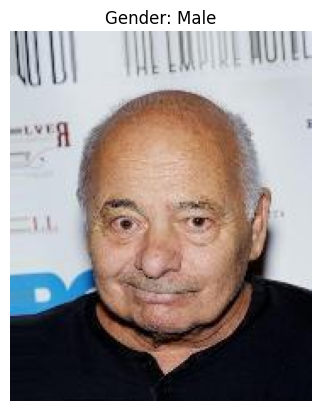

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os

# Ambil baris pertama dari identity_df
sample_row = identity_df.iloc[0]

# Path gambar
img_path = os.path.join(image_folder, sample_row['image_filename'])

# Buka gambar
image = Image.open(img_path)

# Konversi label numeric ke teks
gender_label = 'Male' if sample_row['gender'] == 1 else 'Female'

# Tampilkan gambar dan label
plt.imshow(image)
plt.axis('off')
plt.title(f"Gender: {gender_label}")
plt.show()

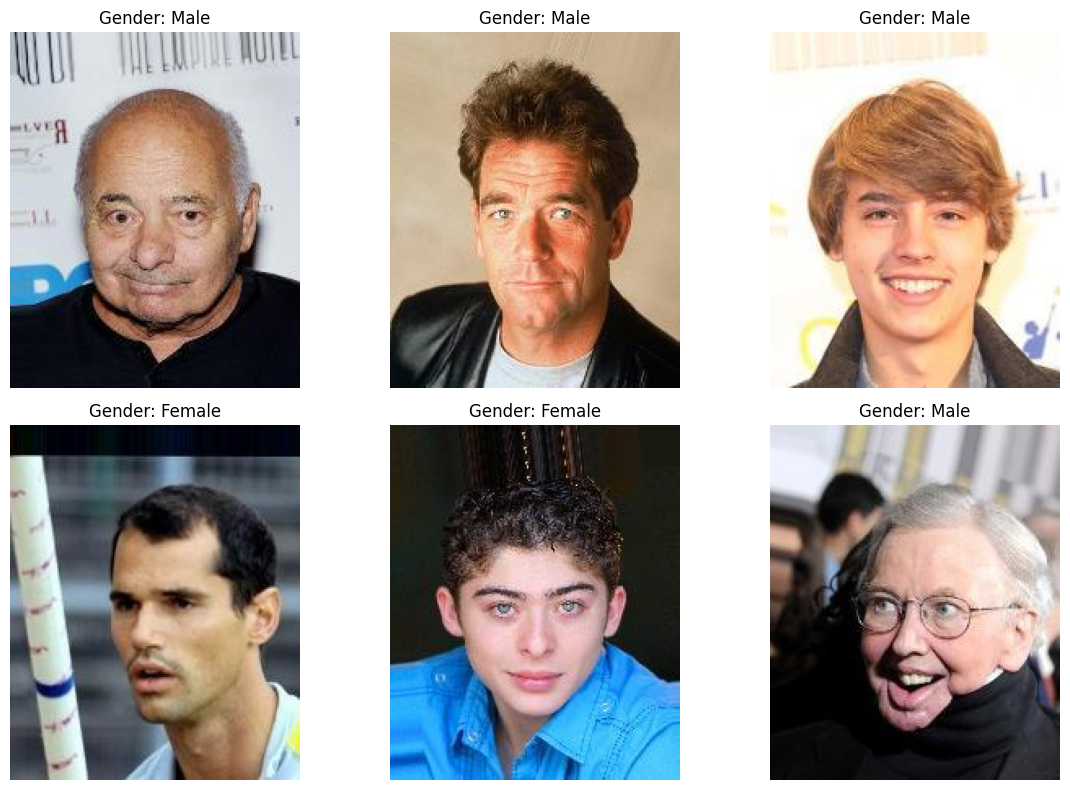

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    row = identity_df.iloc[i]
    img_path = os.path.join(image_folder, row['image_filename'])
    image = Image.open(img_path)
    label = 'Male' if row['gender'] == 1 else 'Female'
    ax.imshow(image)
    ax.set_title(f"Gender: {label}")
    ax.axis('off')

plt.tight_layout()
plt.show()

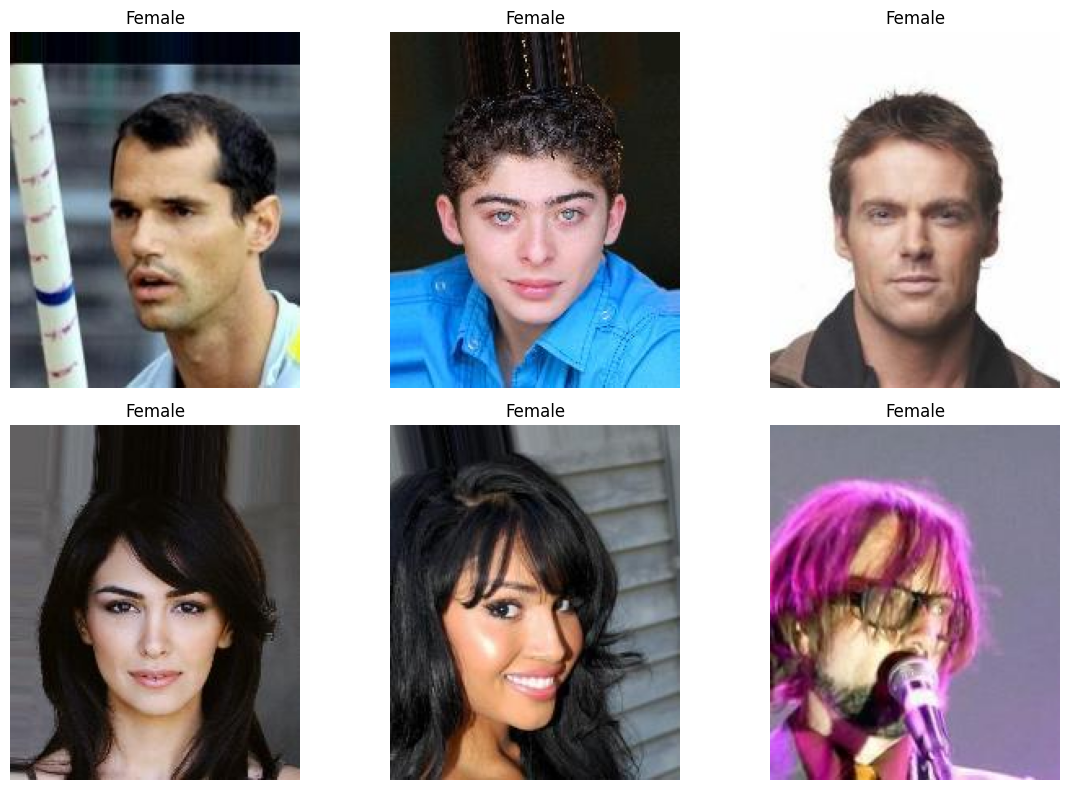

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    row = female_df.iloc[i]
    img_path = os.path.join(image_folder, row['image_filename'])
    image = Image.open(img_path)
    ax.imshow(image)
    ax.set_title("Female")
    ax.axis('off')

plt.tight_layout()
plt.show()

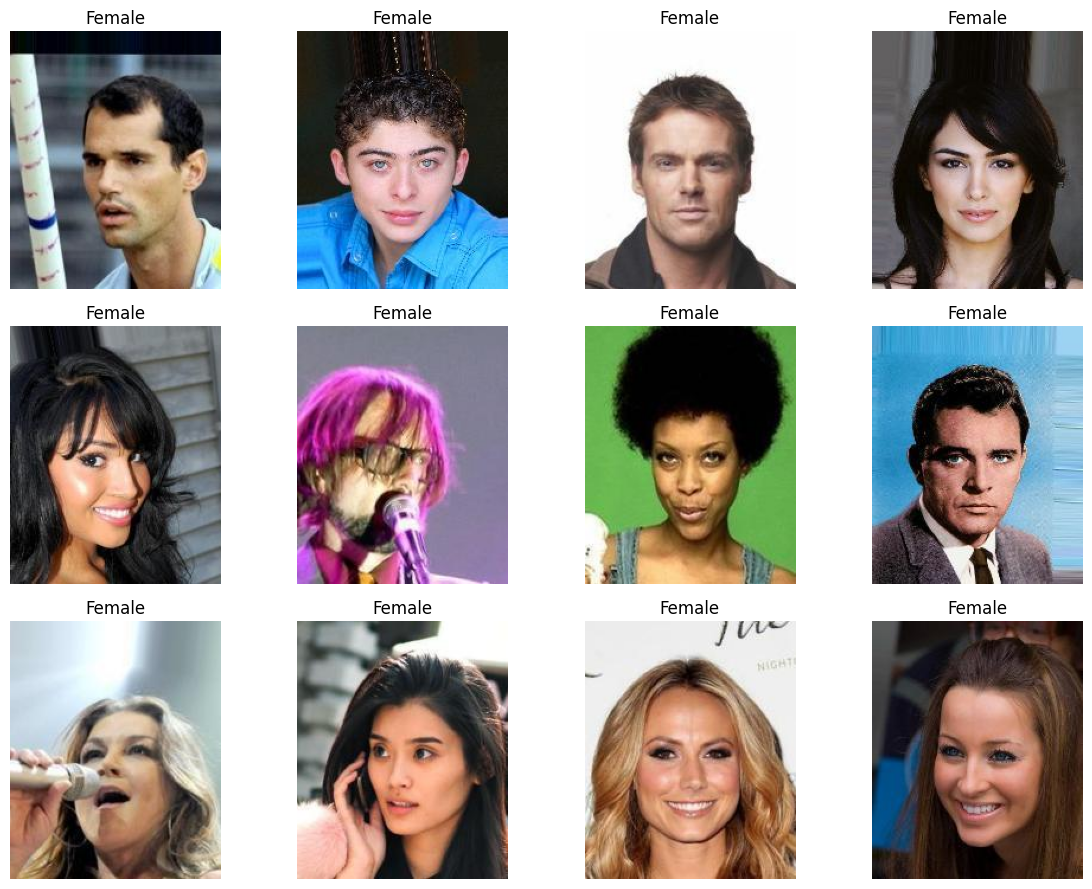

In [ ]:
female_df = identity_df[identity_df['gender'] == 0].reset_index(drop=True)

fig, axes = plt.subplots(3, 4, figsize=(12, 9))  # tampilkan 12 sample
for i, ax in enumerate(axes.flat):
    row = female_df.iloc[i]
    img_path = os.path.join(image_folder, row['image_filename'])
    image = Image.open(img_path)
    ax.imshow(image)
    ax.set_title("Female")
    ax.axis('off')

plt.tight_layout()
plt.show()